## **EDA: Exploratory Data Analysis**

*TERCERA FASE*

El analisis exploratorio de datos (EDA) consiste en realizar las verificaciones y eliminaciones de datos nulos, registros o filas duplicadas, pero ya no generales como se realizó en la etapa anterior de ETL, sino las correspondientes a determinados campos que fueron desempaquetados de las columnas anidadas; y, consecuentemente, las transformaciones a los formatos de datos de algunas columnas para posteriormente realizar el analisis eficiente y efectivo de los datos.

In [5]:
## Se importan las librerías necesarias para esta tercera fase de transformación de datos - EDA
import pandas as pd
from datetime import datetime
import html
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [2]:
# Se cargan los datos guardados en la etapa anterior (ETL) en formato CSV a sus respectivos DataFrames.
df_games = pd.read_csv('Data2_ETL_out\\ETL_games.csv')
df_reviews = pd.read_csv('Data2_ETL_out\\ETL_reviews.csv')
df_items = pd.read_csv('Data2_ETL_out\\ETL_items.csv')

In [6]:
## DEPURACIÓN DE LOS DATOS A NECESITAR POR SEPARADO

'''df_games'''

# Conversión a tipo datetime para generar la columna RELEASE_YEAR
df_games.release_date = pd.to_datetime(df_games.release_date, format='%Y-%m-%d', errors='coerce')
df_games['release_year'] = df_games['release_date'].dt.year

# Manejo de datos faltantes
df_games.genres.fillna(df_games.tags, inplace=True)
df_games.dropna(subset='genres',inplace=True)
df_games.dropna(subset='release_date',inplace=True)
df_games.dropna(subset='release_year',inplace=True)

# Cambiar el nombre de la columna "id" por "item_id"
df_games = df_games.rename(columns={'id': 'item_id'})

# Conversión de "item_id" y "release_year" a valores enteros
df_games.item_id = df_games.item_id.astype(int)
df_games.release_year = df_games.release_year.astype(int)

'''df_reviews'''

# Conversión a tipo datetime para generar la columna POSTED_YEAR

# No se aplicó el método directo aplicando en df_games porque se perdería el 20% de los datos porque no tenía el año
# por eso primero se aplica rellenar los años faltantes como el siguiente al último registrado, año en el que se 
# asume se realizó el estudio o captura de datos.
df_reviews.posted  = df_reviews.posted.apply(lambda x: str.replace(x,".",""))
df_filtered        = df_reviews[~df_reviews.posted.str.contains(',')]
df_filtered.posted = df_filtered.posted+', 2016'
df_reviews.loc[df_filtered.index] = df_filtered

# Conversión previa a formato fecha para aplicar la generación definitva
df_reviews.posted  = df_reviews.posted.apply(lambda x: datetime.strptime(x, "Posted %B %d, %Y"))

# Generación de la columna POSTED_YEAR a partir de la columna posted ya convertida a fecha
df_reviews["posted_year"] = df_reviews.posted.dt.year

# Convertimos la columna 'review' en tipo string para aplicar nuestrop modelo de analisis de sentimiento
df_reviews['review'] = df_reviews['review'].astype(str)

# Conversión a minúsculas de los valores de la columna REVIEW para los procesos de clasificación
df_reviews.review  = df_reviews.review.str.lower()

C:\Users\JC\AppData\Local\Temp\ipykernel_7520\4279218437.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_games.genres.fillna(df_games.tags, inplace=True)


In [7]:
print("df_games = [" + ", ".join(["'" + col + "'" for col in df_games.columns]) + "]")
print("df_reviews = [" + ", ".join(["'" + col + "'" for col in df_reviews.columns]) + "]")
print("df_items = [" + ", ".join(["'" + col + "'" for col in df_items.columns]) + "]")

df_games = ['genres', 'app_name', 'release_date', 'tags', 'item_id', 'release_year']
df_reviews = ['user_id', 'funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review', 'posted_year']
df_items = ['user_id', 'items_count', 'item_id', 'item_name', 'playtime_forever', 'playtime_2weeks']


In [8]:
## ELIMINACIÓN DE COLUMNAS NIVEL 2

## Después de revisar el diccionario de datos y tras la evaluación de los campos necesarios para los modelos
## decidí eliminar columnas SECUNDARIAS innecesarias por estar duplicadas, vacías o con valores de cero.

df_games   = df_games.drop(columns= ['release_date', 'tags'])
df_reviews = df_reviews.drop(columns=['funny', 'posted', 'last_edited', 'helpful'])
df_items   = df_items.drop(columns=['items_count', 'playtime_2weeks'])

In [10]:
## CREACIÓN DE LOS CAMPOS DE ANÁLISIS DE SENTIMIENTOS

# Descarga el lexicon necesario para el análisis de sentimientos
nltk.download('vader_lexicon')

# Crear una instancia del analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Calcula el puntaje de sentimiento para cada reseña y crea una nueva columna "sentiment"
df_reviews['sentiment'] = df_reviews.review.apply(lambda x: sia.polarity_scores(x)['compound'])

# Define umbrales para clasificar las reseñas en positivas, neutrales y negativas
umbral_positivo = 0.2
umbral_negativo = -0.2

# Crea la columna "sentiment_analysis" para clasificar en positivo, neutral y negativo
df_reviews['sentiment_analysis'] = df_reviews.sentiment.apply(lambda x: 2 if x > umbral_positivo else (0 if x < umbral_negativo else 1))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Definitive Dataframes (df) ##

_df_games_
*   genre
*   app_name
*   release_year
*   item_id

_df_items_
*   user_id
*   item_id
*   playtime_forever

_df_reviews_
*   user_id
*   item_id
*   review
*   sentiment
*   sentiment_analysis

## *GRAPHIC ANALYSIS*

***10 TOP GAMES***

Estos son los 10 juegos con más y menos reviews, es decir que pueden ser los juegos más jugados por la comunidad de Steam, y lo contrario.


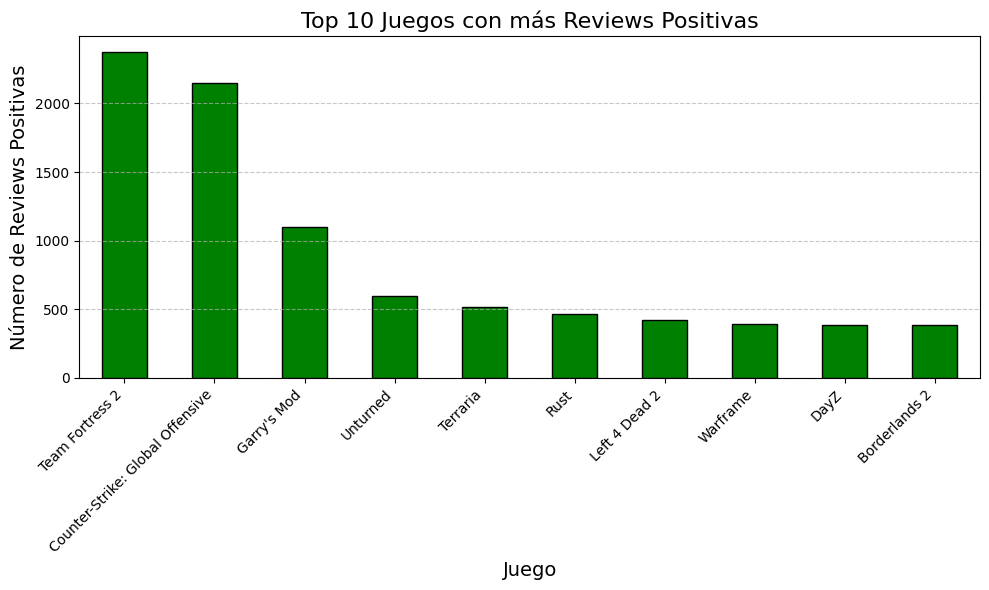

In [14]:
# Juegos con mayor cantidad de sentimientos positivos
# Realiza un merge (fusión) basado en la columna 'item_id'
df_gamerev = pd.merge(df_reviews, df_games, on='item_id')

# Filtra sólo las reviews recomendadas (positivos: valor 2)
df_rec_reviews = df_gamerev[df_gamerev.sentiment_analysis == 2]

# Cuenta reviews recomendadas por juego y selecciona sólo las 10 primeras
df_rev_by_game = df_rec_reviews.app_name.value_counts().head(10)

# Crea el gráfico de barras para revisiones recomendadas por juego
plt.figure(figsize=(10, 6))
df_rev_by_game.plot(kind='bar', color='green', edgecolor='black')
plt.title('Top 10 Juegos con más Reviews Positivas', fontsize=16)
plt.xlabel('Juego', fontsize=14)
plt.ylabel('Número de Reviews Positivas', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

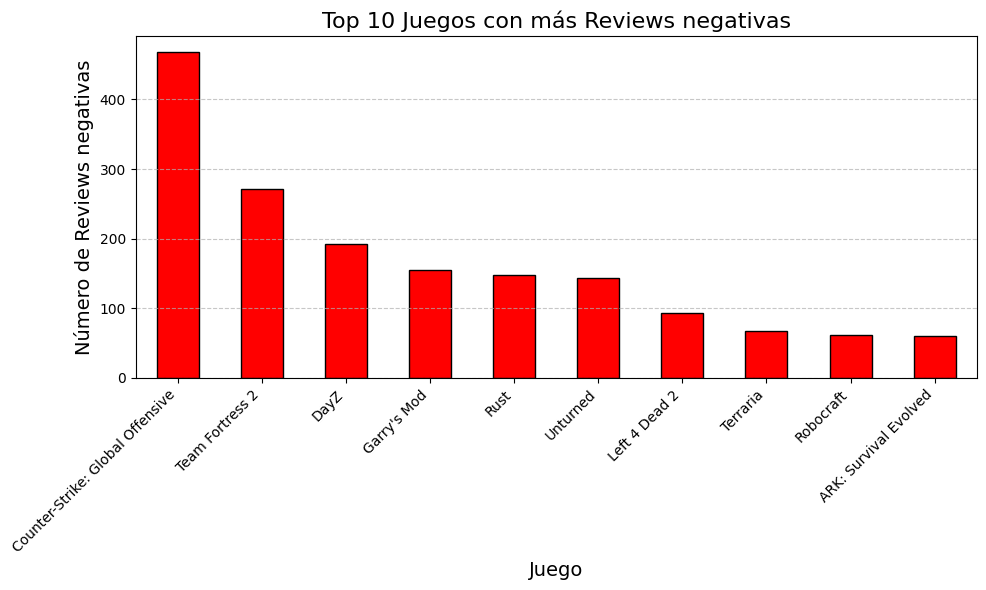

In [15]:
# Juegos con mayor cantidad de sentimientos negativos. Muy similar al gráfico anterior, pero con datos contrarios
# Realiza un merge (fusión) basado en la columna 'item_id'
df_gamerev = pd.merge(df_reviews, df_games, on='item_id')

# Filtra solo las reviews no recomendadas (negativos: valor 0)
df_rec_reviews = df_gamerev[df_gamerev.sentiment_analysis == 0]

# Cuenta reviews recomendadas por juego y selecciona sólo las 10 primeras
df_rev_by_game = df_rec_reviews.app_name.value_counts().head(10)

# Crea el gráfico de barras para revisiones recomendadas por juego
plt.figure(figsize=(10, 6))
df_rev_by_game.plot(kind='bar', color='red', edgecolor='black')
plt.title('Top 10 Juegos con más Reviews negativas', fontsize=16)
plt.xlabel('Juego', fontsize=14)
plt.ylabel('Número de Reviews negativas', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


*CONCLUSIÓN*

*A partir de los 2 gráficos, aparentemente opuestos, los 2 primeros lugares en cada uno de éstos, son los mismos sólo con el orden invertido. Es algo paradógico. Sin embargo, hay una explicación posible: **la fidelidad de los usuarios hacia su juego**, es decir, de los casi 2500 usuarios que recomendaron el primer juego, porque era su juego favorito, casi 500 hicieron comentario negativo del segundo; y, viceversa, de los casi 2100 usuarios que recomendaron el segundo, casi 300 hicieron comentario negativo del primero.*

***TOP REVIEWS YEAR***

Evolución de los niveles de comentario por años.

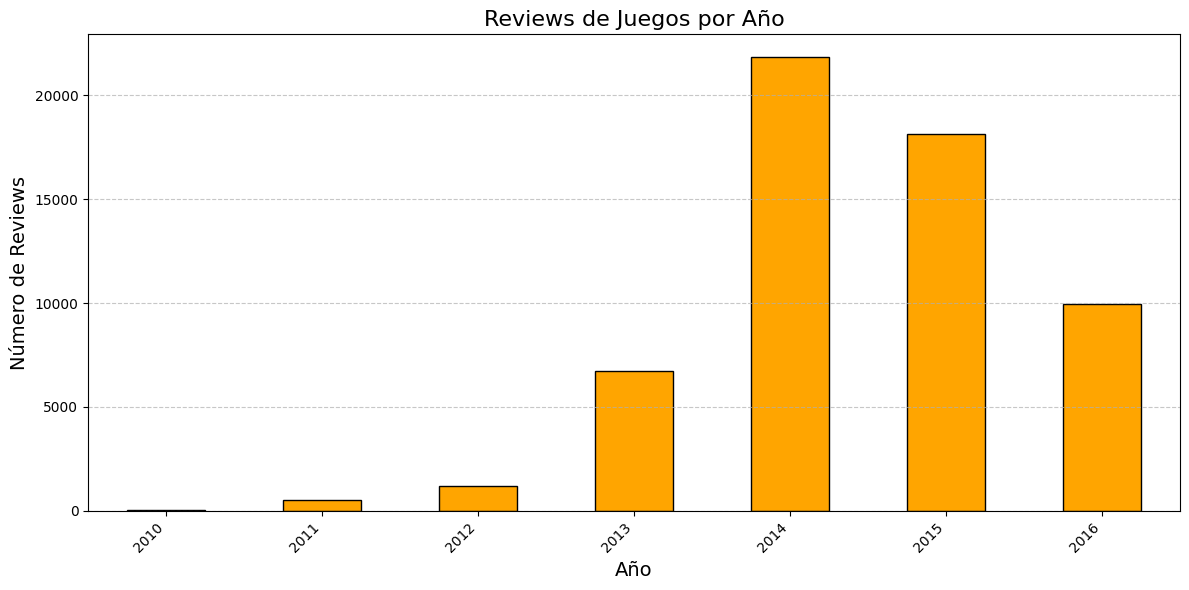

In [18]:
# Determina la cuenta de reviews por año
reviews_by_year = df_reviews.posted_year.value_counts()

# Ordena los resultados por año
reviews_by_year = reviews_by_year.sort_index()

# Crea el gráfico de barras para reviews por año
plt.figure(figsize=(12, 6))
reviews_by_year.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Reviews de Juegos por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Esta gráfica nos muestra los años de las reviews realizadas por los usuarios. Aquí podemos ver un crecimiento muy notable en los años 2014 y 2015 lo cual nos podría nos da indicios para aseverar  un crecimiento de la plataforma en los últimos años, aunque también deberia estar relacionada con el incremento de número total de jugadores.
El descenso en el último año es un indicador de que falta fomentar los reviews en los usuarios.


***WORDCLOUD***

*1. Nube de palabras de los reviews con los juegos más comprados.*

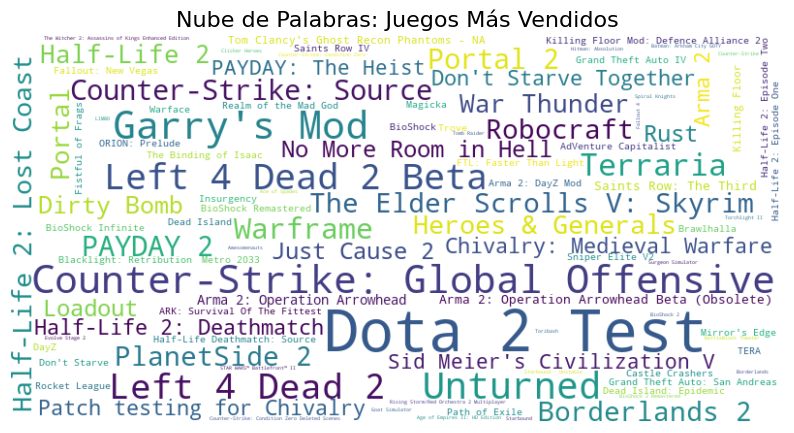

In [20]:
## CREACIÓN DE LA NUBE DE PALABRAS DE REVISIONES CON LOS JUEGOS MÁS COMPRADOS

# Agrupa por 'item_name' y cuenta la frecuencia de cada juego
frecuencia_juegos = df_items.item_name.value_counts()

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(frecuencia_juegos)

# Muestra la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Juegos Más Comprados', fontsize=16)
plt.show()


Esta nube de palabras resaltan los juegos como **Dota 2 Test**, **Counter-Strike: Global Offensive** y **Garry's Mod**, en ese orden como los juegos más comprados por los usuarios.

*2. Nube de palabras de los géneros con más juegos*

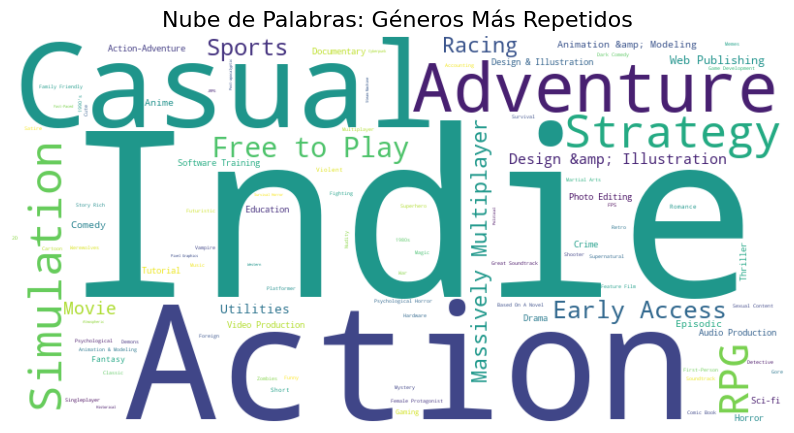

In [21]:
# Nube de palabras de los géneros con más juegos

# Convertir las cadenas de 'genres' a listas
df_games.genres = df_games.genres.apply(lambda x: eval(x) if isinstance(x, str) else x)

# Convertir la columna 'genres' a listas y combinar todas las listas en una sola lista
todos_los_generos = [generos for lista_generos in df_games['genres'].dropna() for generos in lista_generos]

# Contar la frecuencia de cada género
frecuencia_generos = pd.Series(todos_los_generos).value_counts()

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(frecuencia_generos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Géneros Más Repetidos', fontsize=16)
plt.show()



En este gráfico se obsera que los géneros más jugados por los usuarios son: **Indie**, **Action**, **Casual** y **Adventure**, en ese orden.

In [22]:
## GENERACIÓN DE LA LISTA DE GÉNEROS DE JUEGOS QUE MÁS EXISTEN EN EL MERCADO
df_games_exp  = df_games.explode('genres')
genres_unq    = df_games_exp.genres.value_counts()
df_genres_unq = genres_unq.reset_index()
df_genres_unq.columns=['genre','num_g']

# En total habían 200 géneros, pero muchos tenía una escasa aparición en los datos, es decir eran OUTLIERS
# los cuales intenté eliminar creando la función del rango intercuartílico: 
# df_genres_unq= eliminar_outliers_iqr(df_genres_unq, 'num_g')
# sin embargo, cuando lo apliqué noté que no era efectivo, porque eliminaba a los más representativos
# así que quité la su definición de la función y comenté la sentencia (2 líneas arriba).
# Por lo tanto, determiné que sería muy recomendable sólo considerar los que tengan más de 100 apariciones
# de forma arbitraria, pero muy intuitivamente.
df_genres_unq=df_genres_unq[df_genres_unq.num_g>100]
df_genres_unq=df_genres_unq.drop(columns=['num_g'])

# Reemplazar los caracteres de escape presentes en la columna GENRE
df_genres_unq.genre = df_genres_unq.genre.apply(lambda x: html.unescape(x))

In [24]:
## CREACIÓN DE DATA DE ANÁLISIS DE SENTIMIENTOS QUE SERVIRÁ PARA LAS FUNCIONES DE RECOMENDACIONES DE USUARIOS

df_dummies = pd.get_dummies(df_reviews['sentiment_analysis'], prefix='sentim')
df_SentimAnalysis = pd.concat([df_reviews[['item_id','user_id','recommend','posted_year']], df_dummies], axis=1)
df_SentimAnalysis = pd.merge(df_SentimAnalysis,df_games[["item_id","app_name"]], on="item_id", how="inner")
df_SentimAnalysis = df_SentimAnalysis.rename(columns={'sentim_0':'Negativo', 'sentim_1': 'Neutro', 'sentim_2': 'Positivo'})
df_SentimAnalysis.drop_duplicates(inplace=True)

In [25]:
# GUARDAR LOS DATOS EN ARCHIVOS CSV
# salvar los datos de este dataframe para su posterior uso y evitar doble codificación y pérdida de tiempo
df_games.to_csv('Data3_EDA_out\\EDA_games.csv', index=False)
df_reviews.to_csv('Data3_EDA_out\\EDA_reviews.csv', index=False)
df_items.to_csv('Data3_EDA_out\\EDA_items.csv', index=False)
df_genres_unq.to_csv('Data3_EDA_out\genres.csv', index=False)
df_SentimAnalysis.to_csv('Data3_EDA_out\\SentimAnalysis.csv', index=False)